# Predicting car prices from the K-nearest neighbors algorithm

The aim of this project is to practice machine learning workflow using the scikit-learn library. We will attempt to predict the market price of a car by using numerical information contained in an automobile data set from UCI (available [here](https://archive.ics.uci.edu/ml/datasets/automobile)). Categorical features of the car will be ignore for the sake of this project, because they are incompatible with the multi-variate k-nearest algorithm that we are using.

In [1]:
import pandas as pd
import numpy as np

col_names = [
    'symboling',
    'normalized-losses',
    'make',
    'fuel_type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price',
]
cars = pd.read_csv('imports-85.data', header=None, names=col_names)
cars.head()

,symboling,normalized-losses,make,fuel_type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The numeric columns that could possibly be included in our model are:

* symboling
* normalized-losses
* num-of-doors
* wheel-base
* length
* width
* height
* curb-weight
* num-of-cylinders
* engine-size
* bore
* stroke
* compression-ratio
* horsepower
* peak-rpm
* city-mpg
* highway-mpg

The target column will be **'price'**.


## Data cleaning

Now let's give the dataset a bit of cleaning.

In [2]:
# Replace '?' with np.nan
columns_with_question_marks = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
cars[columns_with_question_marks] = cars[columns_with_question_marks].replace('?', np.nan).astype(float)

# Map string numbers to int (for the num-of-doors and num-of-cylinders columns)

columns_with_string_numbers = ['num-of-doors', 'num-of-cylinders']
map_ = {'two' :2, 'three':3, 'four':4, 'five':5, 'six':6, 'eight':8, 'twelve':12}
for col in columns_with_string_numbers:
    cars[col] = cars[col].replace('?', np.nan)
    cars[col] = cars[col].map(map_).astype(float)

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    164 non-null float64
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num-of-doors         203 non-null float64
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null float64
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression-ratio    205 non-null float64
horsepower           203 no

We will drop the **'normalized-losses'** column because it contains too many null values. Dropping the rows would penalize other columns too much. At the same time, we will drop the non-numeric columns since they aren't relevant to our algorithm. Then, we will drop rows for the other null values - they are only present in small number so this is a negligeable loss. We will end up with a dataframe containing non-null numerical values and columns of equal size. 

In [3]:
cols_to_drop = ['normalized-losses', 'make', 'fuel_type', 'aspiration', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']
cars.drop(cols_to_drop, axis=1, inplace=True)
cars.dropna(axis=0, inplace=True)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 17 columns):
symboling            193 non-null int64
num-of-doors         193 non-null float64
wheel-base           193 non-null float64
length               193 non-null float64
width                193 non-null float64
height               193 non-null float64
curb-weight          193 non-null int64
num-of-cylinders     193 non-null float64
engine-size          193 non-null int64
bore                 193 non-null float64
stroke               193 non-null float64
compression-ratio    193 non-null float64
horsepower           193 non-null float64
peak-rpm             193 non-null float64
city-mpg             193 non-null int64
highway-mpg          193 non-null int64
price                193 non-null float64
dtypes: float64(12), int64(5)
memory usage: 27.1 KB


The next step is to rescale the data, so that every column contributes equally to the k-nearest neighbors algorithm. To this end, we will apply min-max normalization such that every value is contained between 0 and 1.

In [4]:
# Save price column (no normalization for target column)
price = cars['price'].copy()
# Rescale using min-max normalization
cars = (cars - cars.min()) / (cars.max() - cars.min())
# Restore price column
cars['price'] = price
# Display first 5 rows
cars.head()

,symboling,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.111111,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,1.0,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.111111,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.6,0.0,0.230321,0.449254,0.444444,0.383333,0.517843,0.333333,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.8,1.0,0.384840,0.529851,0.504274,0.541667,0.329325,0.111111,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.8,1.0,0.373178,0.529851,0.521368,0.541667,0.518231,0.222222,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Univariate K-nearest neighbor model

Before applying a multi-variate k-nearest neighbor model, we will begin simple and try a uni-variate k-nearest neighbors model. The data will be split into training and testing sets using k-fold cross validation.

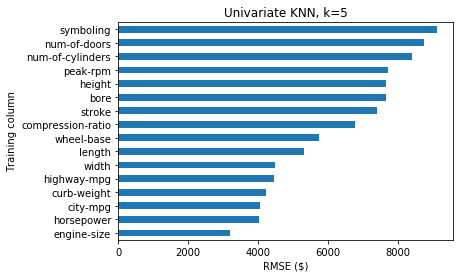

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold

def knn_train_test_univariate(df, train_col, target_col, k=5):
    # Initiate an instance of a K-nearest-neighbor regressor class
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')
    
    # Separate the dataset into 5 folds
    kf = KFold(5, shuffle=True, random_state=1)
    
    mses = cross_val_score(knn, 
                           df[[train_col]], 
                           df[target_col], 
                           scoring='neg_mean_squared_error',
                           cv=kf)
            
    rmse = np.sqrt(np.mean(np.abs(mses)))

    return rmse

# Try the model for each training column (all except 'price' which is target)
training_cols = list(cars.columns)
training_cols.remove('price')
uni_results = {}
for col in training_cols:
    rmse = knn_train_test_univariate(cars, col, 'price')
    uni_results[col] = rmse

# Compile results in a dataframe
df_results = pd.DataFrame(uni_results.values(), index=uni_results.keys(), columns=['RMSE']).sort_values(by='RMSE')

# Display dataframe as a bar plot
import matplotlib.pyplot as plt
ax = df_results.plot.barh(legend=False)
ax.set_xlabel('RMSE ($)')
ax.set_ylabel('Training column')
ax.set_title('Univariate KNN, k=5')
plt.show()


For now we have been using the default number of nearest neighbors, k=5. Let's observe how changing the value of k from 1 to 20 will affect RMSE.

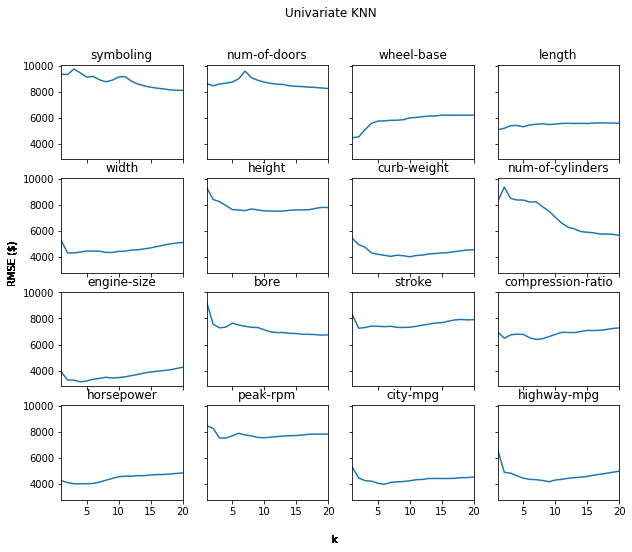

In [13]:
k_list = list(range(1,21))

training_cols = list(cars.columns)
training_cols.remove('price')

# Results will be compiled in this dataframe
df_results = pd.DataFrame(index=k_list, columns=training_cols)

for k in k_list:
    # Try the model for each individual column
    for col in training_cols:
        rmse = knn_train_test_univariate(cars, col, 'price', k=k)
        df_results.loc[k, col] = rmse


# Display results in a line plot
fig, ax = plt.subplots(4, 4, figsize=(10,8), sharey=True, sharex=True)
ax = ax.reshape(16)
for ii, col in enumerate(training_cols):
    df_results.plot(ax=ax[ii], use_index=True, y=col, legend=False)
    ax[ii].set_title(col)
    fig.text(0.5, 0.05, 'k')
    fig.text(0.05, 0.5, 'RMSE ($)', rotation=90)
    fig.suptitle('Univariate KNN')

    
plt.show()

There is no evident trend in changing the k parameter. For example, **'num-of-cylinders'** columns greatly benefits from a high k value and **'wheel-base'** is optimal with a low k value. Most columns see a small increase in RMSE with k. A value around 10 seems to be a good compromise for most columns. 

## Multivariate K-nearest neighbor model
Now let's move on to a multi-variate model. We will start with the column that gave the best univariate result (lowest rmse) and increment by adding the next best column to the model.

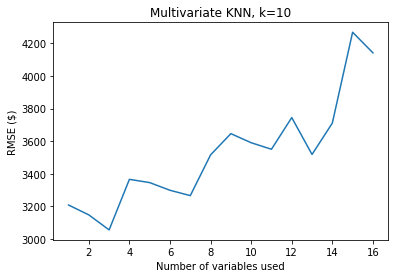

In [15]:
def knn_train_test_multivariate(df, train_cols, target_col, k=5):
    # Initiate an instance of a K-nearest-neighbor regressor class
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')
    
    # Separate the dataset into 5 folds
    kf = KFold(5, shuffle=True, random_state=1)
    
    mses = cross_val_score(knn, 
                           df[train_cols], 
                           df[target_col], 
                           scoring='neg_mean_squared_error',
                           cv=kf)
            
    rmse = np.sqrt(np.mean(np.abs(mses)))
    
    return rmse

# Sort univariate rmse results from lowest to highest
training_cols = sorted(uni_results.keys(), key=uni_results.__getitem__)

# Calculate RMSE for each combinaison of columns
multi_results = {}
for ii in range(len(training_cols)):
    # On each increment, keep the same variable list but add one variable. 
    # We choose k=5 because that's how the univariate rmse were sorted.
    rmse = knn_train_test_multivariate(cars, training_cols[:1+ii], 'price', k=5)
    multi_results[ii+1] = rmse
    
plt.plot(list(multi_results.keys()), list(multi_results.values()))
plt.xlabel('Number of variables used')
plt.ylabel('RMSE ($)')
plt.title('Multivariate KNN, k=10')
plt.show()

Here, adding lots of variables doesn't help much with the RMSE of our predictions. It seems like 3 variables would be best. To continue our grid search, let's select the cases where the number of variables from 1 to 9 and see how the RMSE changes with k.

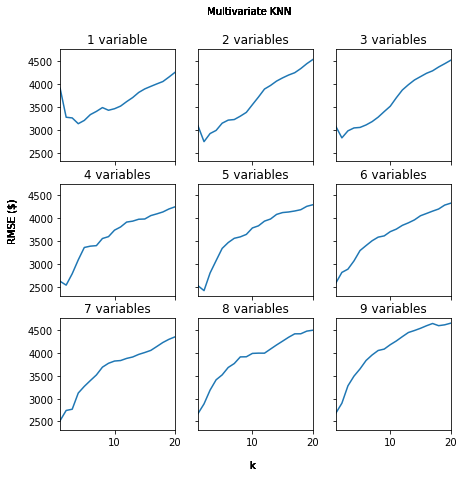

In [22]:
k_list = list(range(1,21))

num_training_cols = list(range(1,10))

# Results will be compiled in this dataframe
df_results = pd.DataFrame(index=k_list, columns=num_training_cols)

# Sort univariate rmse results from lowest to highest
training_cols = sorted(uni_results.keys(), key=uni_results.__getitem__)

for k in k_list:
    # Try the model for each combination of columns
    for num_cols in num_training_cols:
        rmse = knn_train_test_multivariate(cars, training_cols[:num_cols], 'price', k=k)
        df_results.loc[k, num_cols] = rmse


# Display dataframe as a bar plot
fig, ax = plt.subplots(3, 3, figsize=(7,7), sharey=True, sharex=True)
ax = ax.reshape(9)
for ii, num_cols in enumerate(num_training_cols):
    df_results.plot(ax=ax[ii], use_index=True, y=num_cols, legend=False)
    ax[ii].set_title(str(num_cols) + ' variable' + 's'*(num_cols!=1))
    fig.text(0.5, 0.05, 'k')
    fig.text(0.02, 0.5, 'RMSE ($)', rotation=90)
    fig.text(0.5, 0.95, 'Multivariate KNN', ha='center')

    
plt.show()

A low k value seems to yield best results. A higher number of variables performs slightly better with lower k. A final set of hyperparameters could be 5 variables with k=2, which yields the lowest RMSE of \$2425.21.

# Conclusion

In this project, we have used a K-nearest neighbors model to predict the price of cars. The algorithm learned from an automobile data set from UCI (available [here](https://archive.ics.uci.edu/ml/datasets/automobile)). We split the dataset into training and test subsets using 5-fold cross-validation. After a small grid search, we choose hyperparameters of K=5 (number of nearest neighbors) with variables 'engine-size', 'horsepower', 'city-mpg', 'curb-weight', and 'highway-mpg'. This yields a root mean squared error of $$2425.21. The standard deviation of the car prices is \$8089.08, so we gained substantial precision from the model.

To improve the model, we could look at other combinations of variables, instead of moving by increment following the list of best univariate results. The advantage of our method is to optimize computing resources, but we could be missing on a winning combination. We should also implement different random seeds. Indeed, the data contains only 193 rows which is few to train with - leading to potentially big differences due to shuffling. 
